# **ArXiv Research Paper Scraper**

This project is designed to provide a streamlined experience for researchers and enthusiasts to find and organize newly released research papers from [arXiv.org](https://arxiv.org). The application uses **web scraping techniques** to retrieve papers based on user-defined topics and displays the results in an interactive, user-friendly **Streamlit interface**.

---

## **Features of the Application**

### 1. **Search for Specific Topics**
- Users can input a search query (e.g., *machine learning*) in the provided text box.
- The system fetches research papers relevant to the query directly from arXiv's database.

### 2. **Set the Number of Pages to Retrieve**
- Users can define how many pages of results they want to scrape using the increment/decrement buttons.

### 3. **Dynamic Tabular Display**
- Search results are displayed in a **well-organized table** for better readability.
- Each row includes essential details such as:
  - **Paper Title**
  - **Authors**
  - **Submission Date**
  - **Direct PDF Link** for quick access to the full paper.

### 4. **CSV Download Option**
- The entire search result can be downloaded as a **CSV file**, enabling users to save, analyze, or share the data offline.

---

## **Why This Tool is Useful**
- Research involves sifting through vast amounts of papers. This tool simplifies the process by automating the retrieval and organization of relevant research papers.
- The **direct PDF links** save time, while the **CSV download option** supports further offline usage, such as creating bibliographies or conducting meta-analyses.

---

## **Example Workflow**
1. Enter a search query, such as *machine learning*.
2. Adjust the number of pages to scrape (e.g., 1, 2, 3 pages).
3. Click the **Search** button to retrieve results.
4. Review the results in the table:
   - Easily scan through titles, authors, and dates.
   - Click on any PDF link to open the paper in a browser.
5. Click **Download CSV** to save the results for offline use.

---

## **Project Goal**
This project aims to provide a **fast, efficient, and user-friendly way** for researchers to stay updated with the latest advancements in their fields without manually navigating through large repositories.

The combination of **dynamic filtering**, **direct paper access**, and **download capabilities** ensures a seamless experience for users who need quick access to high-quality research.


## **Installing Required Libraries**

Before we dive into building our project, we need to install a few key Python libraries that will power our application. Each library serves a specific purpose, and understanding their roles will help us appreciate their importance. So, let's quickly cover their relevance and get our hands dirty by installing them.

### **1. Streamlit**
Streamlit is the backbone of our project’s user interface. It enables us to create dynamic and interactive web applications with minimal effort. In this project, Streamlit helps us design a clean, user-friendly interface where users can search for research papers and view the results in a table format.

### **2. BeautifulSoup**
BeautifulSoup is a powerful library for web scraping. It simplifies the process of parsing HTML and extracting meaningful data. Here, we use it to fetch research paper details such as titles, authors, and PDF links from the arXiv website.

### **3. Requests**
The `requests` library allows us to send HTTP requests to websites and fetch their content. It serves as the bridge between our code and arXiv’s web pages, retrieving the raw HTML that BeautifulSoup processes.

### **4. Pandas**
Pandas is our go-to library for handling and manipulating data. In this project, we use Pandas to organize the scraped research paper data into a structured tabular format and provide a seamless option to download it as a CSV file.

---

### **Let's Install the Libraries!**
Now that we understand the importance of these libraries, let’s not just sit back. It's time to roll up our sleeves and install them. Run the following code block to install the required packages:




In [20]:
%%capture
!pip install streamlit
!pip install beautifulsoup4==4.12.3
!pip install requests
!pip install pandas

In [21]:
%%writefile app2.py

import requests
from bs4 import BeautifulSoup
import pandas as pd
import streamlit as st

def scrape_arxiv_pagination(url):
    """Gets the pagination links from the specified URL."""
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve data: {response.status_code}")
        return {}

    soup = BeautifulSoup(response.content, 'html.parser')
    nav = soup.find('nav', role='navigation')

    if nav:
        ul_element = nav.find('ul', class_='pagination-list')
        if ul_element:
            pagination_links = {}
            for li in ul_element.find_all('li'):
                a_element = li.find('a')
                if a_element:
                    page_number = a_element.text.strip()
                    link = f"https://arxiv.org{a_element['href']}"
                    pagination_links[page_number] = link
            return pagination_links
    return {}

def scrape_research_papers(url):
    """Gets the details of research papers from the specified URL."""
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve data: {response.status_code}")
        return pd.DataFrame()

    soup = BeautifulSoup(response.content, 'html.parser')
    content_div = soup.select_one('div.content')

    if not content_div:
        print("No content found.")
        return pd.DataFrame()

    ol_element = content_div.find('ol')
    if not ol_element:
        print("No ordered list found.")
        return pd.DataFrame()

    results = []
    for li in ol_element.find_all('li', class_='arxiv-result'):
        pdf_link = li.find('a', href=lambda x: x and 'pdf' in x)
        title = li.find('p', class_='title is-5 mathjax')
        authors = li.find('p', class_='authors')
        submission_info = li.find('p', class_='is-size-7')

        pdf_url = pdf_link['href'] if pdf_link else None
        title_text = title.get_text(strip=True) if title else None

        # Remove "Authors:" prefix and strip whitespace
        authors_text = authors.get_text(strip=True).replace("Authors:", "").strip() if authors else None
        submission_date = submission_info.get_text(strip=True) if submission_info else None

        results.append({
            'Title': title_text,
            'Authors': authors_text,
            'Submission Date': submission_date,
            'PDF Link': f'{pdf_url}' if pdf_url else "N/A"  # Format PDF link for Markdown
        })

    df = pd.DataFrame(results)

    return df

# Streamlit Application
def main():
    st.title("ArXiv Research Papers Scraper")

    query = st.text_input("Enter your search query (e.g., quantum machine learning):")

    num_pages = st.number_input("Number of pages to retrieve:", min_value=1, max_value=5, value=1)

    if st.button("Search"):
        base_url = "https://arxiv.org/search/?query=" + query.replace(" ", "+") + "&searchtype=all"

        # Get pagination links
        pagination_links = scrape_arxiv_pagination(base_url)

        all_results_df = pd.DataFrame()

        # Scrape each page based on user input
        for i in range(num_pages):
            page_url = pagination_links.get(str(i + 1))  # Page numbers start from 1
            if page_url:
                results_df = scrape_research_papers(page_url)
                all_results_df = pd.concat([all_results_df, results_df], ignore_index=True)

        # Display results in Streamlit with clickable PDF links using Markdown
        #st.dataframe(all_results_df.to_markdown(escape=False), unsafe_allow_html=True)
        st.dataframe(
            all_results_df,
            column_config={
                'Title': "Title",
                'Title': "Authors",
                'Submission Date': 'Submission Date',

                "PDF Link": st.column_config.LinkColumn("PDF Link"),

            },)
        # Download options
        if not all_results_df.empty:
            csv_file = all_results_df.to_csv(index=False).encode('utf-8')
            st.download_button(
                label="Download CSV",
                data=csv_file,
                file_name='arxiv_results.csv',
                mime='text/csv',
            )

if __name__ == "__main__":
    main()

Overwriting app2.py


### Solution for SSL/TLS Certificate Error
<code>OSError: Could not find a suitable TLS CA certificate bundle,</code>
If you encounter an error related to `certifi` or the SSL context, follow these simple steps to resolve it:

1. Install or upgrade the `certifi` package using the following command:
   ```bash
   pip install --upgrade certifi
```
```
import certifi
import ssl
```
# Set the SSL context with the certifi CA bundle
```
ssl._create_default_https_context = ssl._create_unverified_context
# use this in the place of response variable
response = requests.get(url, verify=certifi.where())
```

# How the Code Works: Explanation of Functions

In this project, I’ve used three key functions to build a streamlined and user-friendly research paper scraper. Here’s a breakdown of their functionality:

---

## **1. scrape_arxiv_pagination**
- **Purpose**: Tracks the pagination links from the ArXiv search results to allow scraping multiple pages.
- **How it Works**:
  1. The `requests` library sends a request to the specified ArXiv URL to fetch the webpage content.
  2. The `BeautifulSoup` library parses the HTML content into a manageable `soup` object.
  3. Locates the navigation bar (`<nav>` tag) containing the pagination links.
  4. Extracts all the page numbers and their respective URLs, storing them in a dictionary.
- **Key Point**:
  - By tracking the pagination links, this function enables users to specify the number of pages to scrape through the interface.
  - This makes the tool flexible and allows users to retrieve data in batches.

---

## **2. scrape_research_papers**
- **Purpose**: Extracts the details of research papers (title, authors, submission date, PDF link) from a single page of results.
- **How it Works**:
  1. Fetches the content of the given ArXiv URL using `requests`.
  2. Parses the HTML into a `soup` object using `BeautifulSoup`.
  3. Locates the `<div>` container with the class `content`, then accesses the ordered list (`<ol>` tag) that holds the search results.
  4. Iterates over each result (tagged with the class `arxiv-result`):
     - Extracts:
       - **Title**: From a `<p>` tag with the class `title`.
       - **Authors**: From a `<p>` tag with the class `authors` (removing the prefix "Authors:").
       - **Submission Date**: From a `<p>` tag with submission info.
       - **PDF Link**: From an anchor tag (`<a>`) that contains the keyword "pdf".
     - Stores all extracted information into a Pandas DataFrame.
- **Key Point**:
  - This function structures data into a clean DataFrame format, making it easier to display in the user interface and allowing efficient manipulation for downloads.

---

## **3. main**
- **Purpose**: Provides the user interface for interacting with the tool, integrates the scraper functions, and presents the results.
- **How it Works**:
  1. **Search Query**: Prompts users to:
     - Enter a topic (e.g., "quantum machine learning").
     - Select the number of pages to scrape using an input field.
  2. **Scraping**:
     - Calls `scrape_arxiv_pagination` to get pagination links.
     - Iteratively scrapes the selected number of pages using `scrape_research_papers`.
  3. **Display Results**:
     - Shows the scraped data in a table format using Streamlit’s `dataframe` feature.
     - Enables clickable PDF links for easy access.
  4. **Download Option**:
     - Allows users to download the scraped results as a CSV file via a download button.

---

### **Key Benefits**
- **Modular Design**: Each function focuses on a specific task for clarity and reuse.
- **User-Friendly**: Streamlit makes it easy for users to interact with the scraper.
- **Efficient**: Users can customize the number of pages to scrape and save results for future reference.

This design ensures a seamless experience for anyone looking to quickly find and organize the latest research papers!


---
The next 4 cells are useful only if you are trying this code in Google Colab. If you are using any other local code editor, these cells are not required.


In [22]:
#local tunnel
!npm install -g localtunnel


changed 22 packages, and audited 23 packages in 1s

3 packages are looking for funding
  run `npm fund` for details

1 moderate severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [23]:
!streamlit run app.py &>/dev/null&

In [26]:
!curl https://loca.lt/mytunnelpassword

34.80.159.60

In [28]:
!lt --port 8501

your url is: https://two-years-wash.loca.lt
^C


---
Here are the final results of the project. This is how the interface looks like.
---

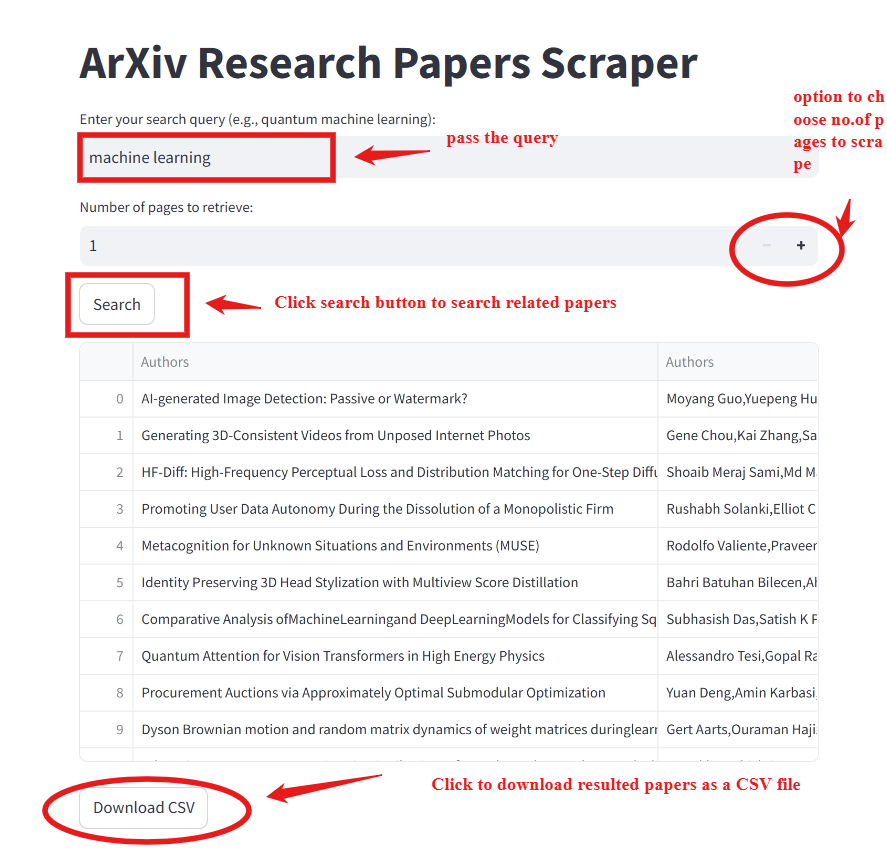

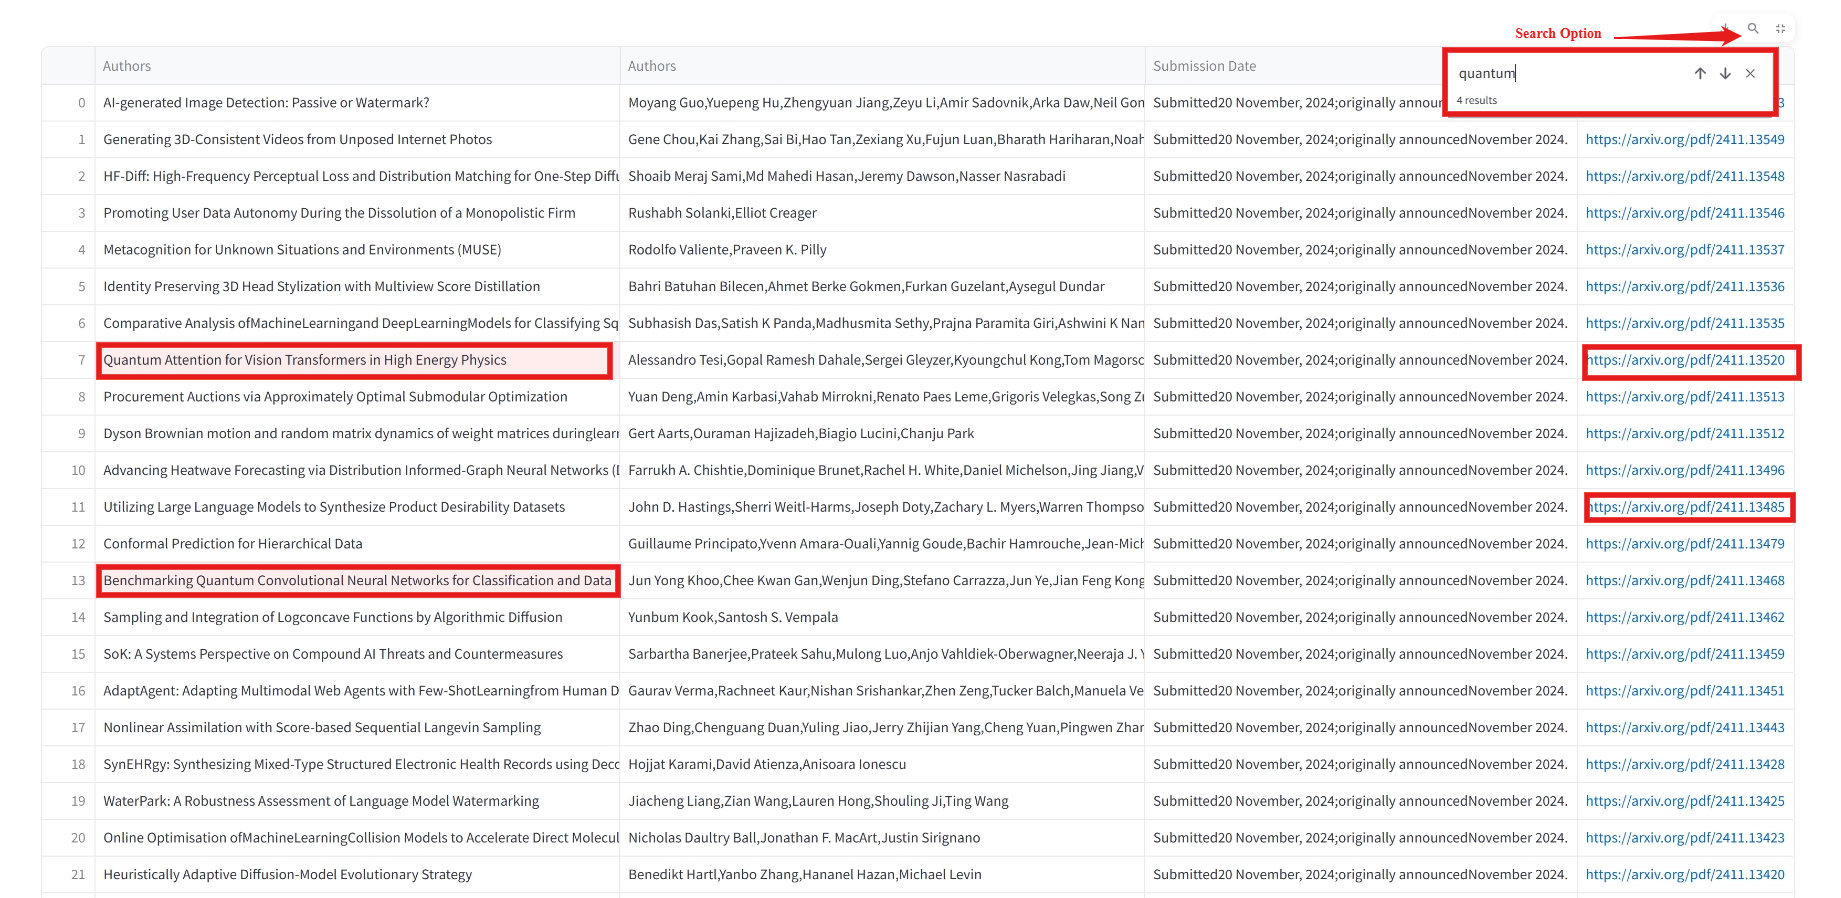

In [ ]:
%%writefile app2.py
# Final Version Code
import certifi
import ssl
import requests
from bs4 import BeautifulSoup
import pandas as pd
import streamlit as st

# Configure SSL context with certifi's CA bundle
ssl._create_default_https_context = ssl._create_unverified_context


def scrape_arxiv_pagination(url):
    """Gets the pagination links from the specified URL."""
    response = requests.get(url, verify=certifi.where())  # Use certifi for SSL
    if response.status_code != 200:
        print(f"Failed to retrieve data: {response.status_code}")
        return {}

    soup = BeautifulSoup(response.content, 'html.parser')
    nav = soup.find('nav', role='navigation')

    if nav:
        ul_element = nav.find('ul', class_='pagination-list')
        if ul_element:
            pagination_links = {}
            for li in ul_element.find_all('li'):
                a_element = li.find('a')
                if a_element:
                    page_number = a_element.text.strip()
                    link = f"https://arxiv.org{a_element['href']}"
                    pagination_links[page_number] = link
            return pagination_links
    return {}


def scrape_research_papers(url):
    """Gets the details of research papers from the specified URL."""
    response = requests.get(url, verify=certifi.where())  # Use certifi for SSL
    if response.status_code != 200:
        print(f"Failed to retrieve data: {response.status_code}")
        return pd.DataFrame()

    soup = BeautifulSoup(response.content, 'html.parser')
    content_div = soup.select_one('div.content')

    if not content_div:
        print("No content found.")
        return pd.DataFrame()

    ol_element = content_div.find('ol')
    if not ol_element:
        print("No ordered list found.")
        return pd.DataFrame()

    results = []
    for li in ol_element.find_all('li', class_='arxiv-result'):
        pdf_link = li.find('a', href=lambda x: x and 'pdf' in x)
        title = li.find('p', class_='title is-5 mathjax')
        authors = li.find('p', class_='authors')
        submission_info = li.find('p', class_='is-size-7')

        pdf_url = pdf_link['href'] if pdf_link else None
        title_text = title.get_text(strip=True) if title else None

        # Remove "Authors:" prefix and strip whitespace
        authors_text = authors.get_text(strip=True).replace("Authors:", "").strip() if authors else None
        submission_date = submission_info.get_text(strip=True) if submission_info else None

        results.append({
            'Title': title_text,
            'Authors': authors_text,
            'Submission Date': submission_date,
            'PDF Link': f'{pdf_url}' if pdf_url else "N/A"  # Format PDF link for Markdown
        })

    df = pd.DataFrame(results)
    return df


# Streamlit Application
def main():
    st.title("ArXiv Research Papers Scraper")

    query = st.text_input("Enter your search query (e.g., quantum machine learning):")

    num_pages = st.number_input("Number of pages to retrieve:", min_value=1, max_value=5, value=1)

    if st.button("Search"):
        base_url = "https://arxiv.org/search/?query=" + query.replace(" ", "+") + "&searchtype=all"

        # Get pagination links
        pagination_links = scrape_arxiv_pagination(base_url)

        all_results_df = pd.DataFrame()

        # Scrape each page based on user input
        for i in range(num_pages):
            page_url = pagination_links.get(str(i + 1))  # Page numbers start from 1
            if page_url:
                results_df = scrape_research_papers(page_url)
                all_results_df = pd.concat([all_results_df, results_df], ignore_index=True)

        # Display results in Streamlit with clickable PDF links using Markdown
        st.dataframe(
            all_results_df,
            column_config={
                'Title': "Title",
                'Title': "Authors",
                'Submission Date': 'Submission Date',
                "PDF Link": st.column_config.LinkColumn("PDF Link"),
            },
        )

        # Download options
        if not all_results_df.empty:
            csv_file = all_results_df.to_csv(index=False).encode('utf-8')
            st.download_button(
                label="Download CSV",
                data=csv_file,
                file_name='arxiv_results.csv',
                mime='text/csv',
            )


if __name__ == "__main__":
    main()
